<img src="img/embarrassing.gif" width=40% align="right">

Understanding Dask
===========

*Dask is a way to represent computations as dictionaries, and then analyze and execute them.*

Dask supports parallel computing.  Internally it executes graphs of tasks with data dependencies.  In this section we talk about what these graphs look like and how to construct them.  We finish with exercises manually building graphs that use basic Pandas functionality.  This is straightforward but somewhat tedious.  We'll automate it in future sections.

You can safely skip this section if you don't care about how dask works internally.

**Related Documentation**

*  [Dask graph specification](http://dask.pydata.org/en/latest/spec.html)
*  [Discussion on custom graphs](http://dask.pydata.org/en/latest/custom-graphs.html)

## Dask task graphs

### Normal Programming

Normally we write functions and then use those function in linear code.  The Python interpreter executes this code from the top down.

### Make functions

In [1]:
def inc(x):
    return x + 1

def add(x, y):
    return x + y

### Call functions in code

In [2]:
a = 1
b = inc(a)

x = 10
y = inc(x)

z = add(b, y)
z

13

Even though some of this work could have happened in parallel, Python went ahead and executed one line after the other sequentially.

If we want to execute code in parallel then we need to stop Python from taking control.

### Computation as a data structure

Instead of writing normal code we store the stages of the computation above as a Python dictionary where each function call becomes a Python tuple.

This is going to look a little strange but we'll have the entire computation stored in a Python data structure that we can manipulate with *other* Python code.

In [3]:
dsk = {'a': 1, 
       'b': (inc, 'a'),
       
       'x': 10,
       'y': (inc, 'x'),
       
       'z': (add, 'b', 'y')}

In [4]:
type(dsk)

dict

We call a dictionary that looks like this a *dask graph*.  A dask graph is just a dictionary.

### Related Approaches to Delayed Evaluation

Representing Python functions as tuples containing function names and arguments may seem strange, but in reality you are already familiar with the style.


In [5]:
# Sometimes we defer compuations with a lambda

x = 15
y = 30
z = lambda: x + y

# z delays the execution of x + y until we call z()
# This is very similar to (add, 'x', 'y')

# Sometimes we defer computations with strings

z = "x + y"
eval(z)

# The variable 'z' stores a string that is a valid Python statement
# We call eval to fully evaluate `z' and obtain the answer.

# Sometimes we use functools.partial
import functools
z = functools.partial(add, x, y)

# Dask delays evaluation with tuples
z = (add, x, y)

### Dask graph definition

To be fully explicit, here is the definition of a dask graph taken from the [dask documentation](http://dask.pydata.org/en/latest/spec.html)

A **dask graph** is a dictionary mapping data-keys to values or tasks.

```python
{'x': 1,
 'y': 2,
 'z': (add, 'x', 'y'),
 'w': (sum, ['x', 'y', 'z'])}
```

A **key** can be any hashable value that is not a task.

```python
'x'
('x', 2, 3)
```

A **task** is a tuple with a callable first element. Tasks represent atomic units of work meant to be run by a single worker.

```python
(add, 'x', 'y')
```

We represent a task as a `tuple` such that the *first element is a callable function* (like `add`), and the succeeding elements are *arguments* for that function.

An **argument** to a task may be one of the following:

1. Any key present in the dask like `'x'`
2. Any other value like `1`, to be interpreted literally
3. Other tasks like `(inc, 'x')`
4. List of arguments, like `[1, 'x', (inc, 'x')]`

So all of the following are valid tasks

```python
(add, 1, 2)
(add, 'x', 2)
(add, (inc, 'x'), 2)
(sum, [1, 2])
(sum, ['x', (inc, 'x')])
(np.dot, np.array([...]), np.array([...]))
```

### Execute dask graphs

The dask library contains functions to execute these dictionaries in parallel with multiple threads or multiple processes.

In [6]:
from dask.threaded import get
get(dsk, 'z')  # Execute in multiple threads

13

In [7]:
from dask.multiprocessing import get
get(dsk, 'z')  # Execute in multiple processes

13

In [8]:
dsk

{'a': 1,
 'b': (<function __main__.inc>, 'a'),
 'x': 10,
 'y': (<function __main__.inc>, 'x'),
 'z': (<function __main__.add>, 'b', 'y')}

So as long as you're willing to write code in this funny way with dictionaries, dask will run your separate functions in parallel.

### Analyze and Visualize Graphs

Because our computation is just a dictionary we can write arbitrary functions to do a variety of useful analyses on these dictionaries.  A simple yet common operation is just to visualize the computation as a visual graph. 

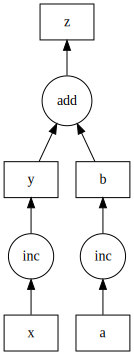

In [10]:
# Requires that you have pydot and graphviz installed
# This isn't a problem if this doesn't work for you
from dask.dot import dot_graph
dot_graph(dsk, format='svg')

That's it
----------

The rest of this tutorial is fancy ways to construct and executing dask graphs.  We won't make any more by hand after this notebook.  If you'd like to learn more, read the [dask graph spec](http://dask.pydata.org/en/latest/spec.html).

Exercise - `read_csv`
------------------------

Let's look again at the exercise of the previous notebook with the accounts csv files. As an exercise we'll parallelize this example by rewriting it manually as a dask graph.  This will be a little tedious but should give us speedups right away.  In future sections we'll learn how dask submodules like `dask.dataframe` automate this work for us.

There are three CSV files in your `data` directory.   We count how many rows are in all of these csv files total.  In normal Python we solve this problem in the following way (version without a for loop).

In [11]:
import pandas as pd

import os
filenames = [os.path.join('data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['data/accounts.0.csv', 'data/accounts.1.csv', 'data/accounts.2.csv']

In [13]:
%%time 

a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
total

CPU times: user 4.09 s, sys: 856 ms, total: 4.94 s
Wall time: 5.07 s


In [14]:
total

15000000

### Construct a dask graph/dictionary for this computation

Just as we turned code that looks like 

```python
y = f(x)
```

into dictionaries like 

```python
{'y': (f, 'x')}
```

We can transform the above calls to `pd.read_csv`, `len`, and `sum` into a dictionary of tuples

In [ ]:
dsk = {'a': (pd.read_csv, filenames[0]),
       'b': ...,
       ...
       'total': ...}

In [16]:
dsk = {'a': (pd.read_csv, filenames[0]),
       'b': (pd.read_csv, filenames[1]),
       'c': (pd.read_csv, filenames[2]),
       'na': (len, 'a'),
       'nb': (len, 'b'),
       'nc': (len, 'c'),
       'total': (sum, ['na', 'nb', 'nc'])}

### Execute your dask graph

We execute dask graphs with the `get` functions.  There is a get function for both multi-threading and multi-processing.  Get takes two arguments

    get(dsk, output_key)

Run the following cells and see how each get function performs.  Why is there a difference?

In [17]:
from dask.threaded import get
%time get(dsk, 'total')

CPU times: user 4.71 s, sys: 1.5 s, total: 6.21 s
Wall time: 2.94 s


15000000

In [18]:
from dask.multiprocessing import get
%time get(dsk, 'total')

CPU times: user 20 ms, sys: 100 ms, total: 120 ms
Wall time: 2.99 s


15000000

## Task graphs created by Dask collections


In the previous notebook we already saw how we could perform the above exercise with a `dask.dataframe` instead of manually creating the task dictionaries. Let's repeat that here and look at the created dask task graph.

In [14]:
import dask.dataframe as dd

In [51]:
df = dd.read_csv("data/accounts.*.csv", blocksize=int(150e6)) # the large blocksize is to simplify the graphs

In [52]:
df

dd.DataFrame<from-de..., npartitions=3>

In [53]:
%time len(df)

CPU times: user 9.82 s, sys: 2.37 s, total: 12.2 s
Wall time: 7.49 s


30000000

### Exercise: Inspect dask graph

Dask `DataFrame` copies a subset of the Pandas API.  

However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, instead they add key-value pairs to an underlying dask graph.

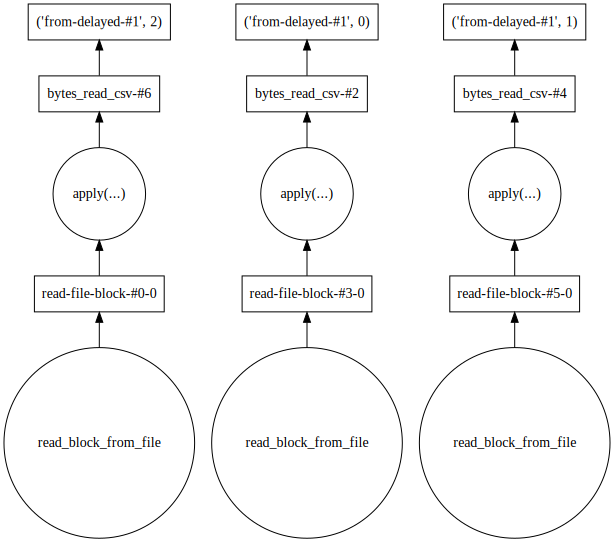

In [18]:
df.visualize(format='svg')

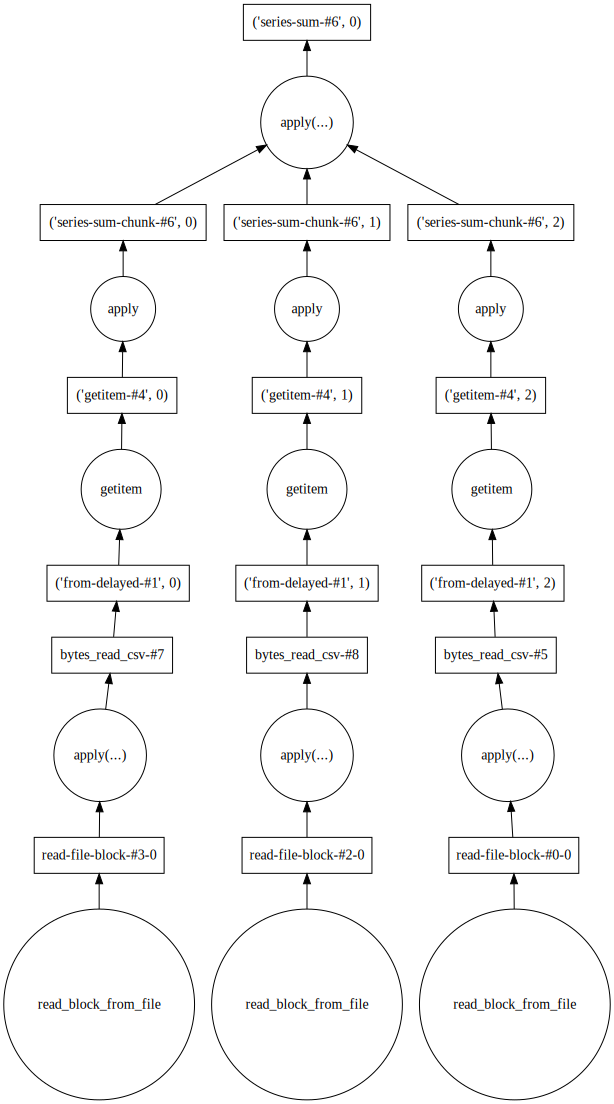

In [20]:
df.amount.sum().visualize(format='svg')

Above we see graphs corresponding to a call to `dd.read_csv` and `df.amount.sum()` on the result.  

Below we see the resulting computations as dictionaries.  You'll note that these dictionaries are a bit more complex than what we built by hand in the last section.  However if you look closely then you'll see all of the familiar elements of `pd.read_csv` and the filenames.

Try changing around the expression `df.amount.sum()` and see how the dictionary and graph change.  Explore a bit with the Pandas syntax that you already know.

In [21]:
df.dask  # .dask attribute contains underlying graph

{'bytes_read_csv-ec104b295250426c2dd53f0c8ae038a9': (<function dask.compatibility.apply>,
  <function dask.dataframe.csv.bytes_read_csv>,
  ['read-file-block-a50aa5758b41c8e4ecc77f62e63a0871-0',
   b'id,names,amount\n',
   (dict, []),
   (dict,
    [['names', dtype('O')],
     ['id', dtype('int64')],
     ['amount', dtype('int64')]]),
   (list, ['id', 'names', 'amount'])],
  (dict, [['enforce', False], ['write_header', False]])),
 'read-file-block-e44d082fe3119b3084597070f1d4b565-0': (<function dask.bytes.local.read_block_from_file>,
  '/home/joris/scipy/SWSC2016-pandas-dask/data/accounts.1.csv',
  0,
  64000000,
  b'\n',
  None),
 'read-file-block-a50aa5758b41c8e4ecc77f62e63a0871-0': (<function dask.bytes.local.read_block_from_file>,
  '/home/joris/scipy/SWSC2016-pandas-dask/data/accounts.0.csv',
  0,
  64000000,
  b'\n',
  None),
 ('from-delayed-a3c9c22a9ef7dabce27b35d7d3988368',
  2): 'bytes_read_csv-121f672cb4626099a450d3d1f9eb06bd',
 'bytes_read_csv-121f672cb4626099a450d3d1f9eb06b

In [22]:
df.amount.sum().dask

{'read-file-block-ff0d7edf91d0065744bc476c16397616-0': (<function dask.bytes.local.read_block_from_file>,
  '/home/joris/scipy/SWSC2016-pandas-dask/data/accounts.2.csv',
  0,
  64000000,
  b'\n',
  None),
 ('from-delayed-a3c9c22a9ef7dabce27b35d7d3988368',
  1): 'bytes_read_csv-e5df9de2ed1964947762a546bf0262cb',
 'read-file-block-e44d082fe3119b3084597070f1d4b565-0': (<function dask.bytes.local.read_block_from_file>,
  '/home/joris/scipy/SWSC2016-pandas-dask/data/accounts.1.csv',
  0,
  64000000,
  b'\n',
  None),
 'read-file-block-a50aa5758b41c8e4ecc77f62e63a0871-0': (<function dask.bytes.local.read_block_from_file>,
  '/home/joris/scipy/SWSC2016-pandas-dask/data/accounts.0.csv',
  0,
  64000000,
  b'\n',
  None),
 ('getitem-cf58324ed8efedd6c6da458378e0fb5e',
  0): (<function _operator.getitem>, ('from-delayed-a3c9c22a9ef7dabce27b35d7d3988368',
   0), 'amount'),
 'bytes_read_csv-121f672cb4626099a450d3d1f9eb06bd': (<function dask.compatibility.apply>,
  <function dask.dataframe.csv.bytes

## Building understanding by visualizing: `dask.diagnostics`

Dask provides several tools to aid in profiling and inspecting dask graph execution. See the documentation for an overview (http://dask.pydata.org/en/latest/diagnostics.html).

In [44]:
df = dd.read_csv("data/accounts.*.csv")

In [45]:
df

dd.DataFrame<from-de..., npartitions=9>

Let's look at the parallel computation of a grouped count operation:

In [46]:
result = df.groupby('names')['amount'].count()

In [ ]:
result.visualize()

Besides the static task graph, we can also visualize the actual computations using dask's Profiler:

In [23]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [28]:
from dask.diagnostics import Profiler, ResourceProfiler, visualize

In [49]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof:
    result.compute()

In [50]:
visualize([prof, rprof])

Column(id='77040535-ecc0-44ba-aebe-e2f043cdded7', ...)

The results from the `Profiler` object show the execution time for each task as a rectangle, organized along the y-axis by worker (in this case threads). Similar tasks are grouped by color, and by hovering over each task one can see the key and task that each block represents.

The results from the `ResourceProfiler object` show two lines, one for total CPU percentage used by all the workers, and one for total memory usage.

Conclusion
------------

We've learned about how dask graph represent computations and how we can execute these computations with dask schedulers / get functions.  We've made a few of these dictionaries by hand.  It's straightforward but perhaps tiresome. We then saw shortly how dask collections can generate similar dictionaries for us, and how we can visualize the execution of those graphs.

In the next notebooks we will see more in depth examples using the Dask collections.